In [1]:
from fredapi import Fred
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime
import missingno as msno
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

## Data collection and cleaning

In [2]:
FRED_API_KEY = "adf5faa6d759eb1f4b335cef60ade574"
START_DATE = "2004-11-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")

fred = Fred(api_key=FRED_API_KEY)

# -----------------------------------------
# DOWNLOAD FRED MACRO DATA
# -----------------------------------------
dxy = fred.get_series("DTWEXBGS", observation_start=START_DATE)
real_yield = fred.get_series("DFII10", observation_start=START_DATE)
breakeven = fred.get_series("T10YIE", observation_start=START_DATE)
fed_funds = fred.get_series("DFF", observation_start=START_DATE)
oil = fred.get_series("DCOILWTICO", observation_start=START_DATE)

cpi = fred.get_series("CPIAUCSL", observation_start=START_DATE)
m2 = fred.get_series("M2SL", observation_start=START_DATE)

# -----------------------------------------
# TRANSFORM MONTHLY SERIES
# -----------------------------------------
cpi = cpi.resample("M").last()
m2 = m2.resample("M").last()

cpi_yoy = cpi.pct_change(12) * 100
m2_yoy = m2.pct_change(12) * 100

# Lag monthly macro to avoid look-ahead bias
cpi_yoy = cpi_yoy.shift(1)
m2_yoy = m2_yoy.shift(1)

# -----------------------------------------
# DOWNLOAD MARKET DATA (YAHOO)
# -----------------------------------------
gold = yf.download("GC=F", start=START_DATE, end=END_DATE)["Close"]
sp500 = yf.download("^GSPC", start=START_DATE, end=END_DATE)["Close"]
vix = yf.download("^VIX", start=START_DATE, end=END_DATE)["Close"]

# -----------------------------------------
# COMBINE DAILY DATA
# -----------------------------------------
daily_data = pd.concat(
    [gold, dxy, real_yield, breakeven, fed_funds, oil, sp500, vix],
    axis=1
)

daily_data.columns = [
    "Gold",
    "DXY",
    "Real_Yield_10Y",
    "Breakeven_10Y",
    "Fed_Funds",
    "WTI_Oil",
    "SP500",
    "VIX"
]

# Forward-fill macro gaps (weekends, holidays)
daily_data = daily_data.ffill()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
START_DATE = "2006-01-01"

# -----------------------------------------
# ADD MONTHLY MACRO (CPI & M2)
# -----------------------------------------
monthly_macro = pd.concat([cpi_yoy, m2_yoy], axis=1)
monthly_macro.columns = ["CPI_YoY", "M2_YoY"]

monthly_macro_daily = monthly_macro.resample("D").ffill()

last_day = gold.index[-1]
monthly_macro_daily = monthly_macro_daily.reindex(
    pd.date_range(start=monthly_macro_daily.index[0], end=last_day, freq="D")
).ffill()

# -----------------------------------------
# FINAL DATASET
# -----------------------------------------
final_data = pd.concat([daily_data, monthly_macro_daily], axis=1)
final_data = final_data.loc[START_DATE:]

final_data = final_data.bfill()

In [4]:
final_data

,Gold,DXY,Real_Yield_10Y,Breakeven_10Y,Fed_Funds,WTI_Oil,SP500,VIX,CPI_YoY,M2_YoY
2006-01-01,517.099976,101.4155,2.06,2.33,4.09,61.06,1248.290039,12.070000,3.338550,3.971091
2006-01-02,517.099976,101.4155,2.06,2.33,4.09,61.06,1248.290039,12.070000,3.338550,3.971091
2006-01-03,530.700012,100.7558,2.03,2.34,4.34,63.11,1268.800049,11.140000,3.338550,3.971091
2006-01-04,533.900024,100.2288,2.01,2.35,4.22,63.41,1273.459961,11.370000,3.338550,3.971091
2006-01-05,526.299988,100.2992,2.04,2.32,4.24,62.81,1273.479980,11.310000,3.338550,3.971091
...,...,...,...,...,...,...,...,...,...,...
2026-02-22,5059.299805,117.9917,1.80,2.28,3.64,66.69,6909.509766,19.090000,2.653304,4.230511
2026-02-23,5204.700195,117.9917,1.77,2.26,3.64,66.36,6837.750000,21.010000,2.653304,4.230511
2026-02-24,5155.799805,117.9917,1.78,2.26,3.64,66.36,6890.069824,19.549999,2.653304,4.230511
2026-02-25,5206.399902,117.9917,1.77,2.28,3.64,66.36,6946.129883,17.930000,2.653304,4.230511


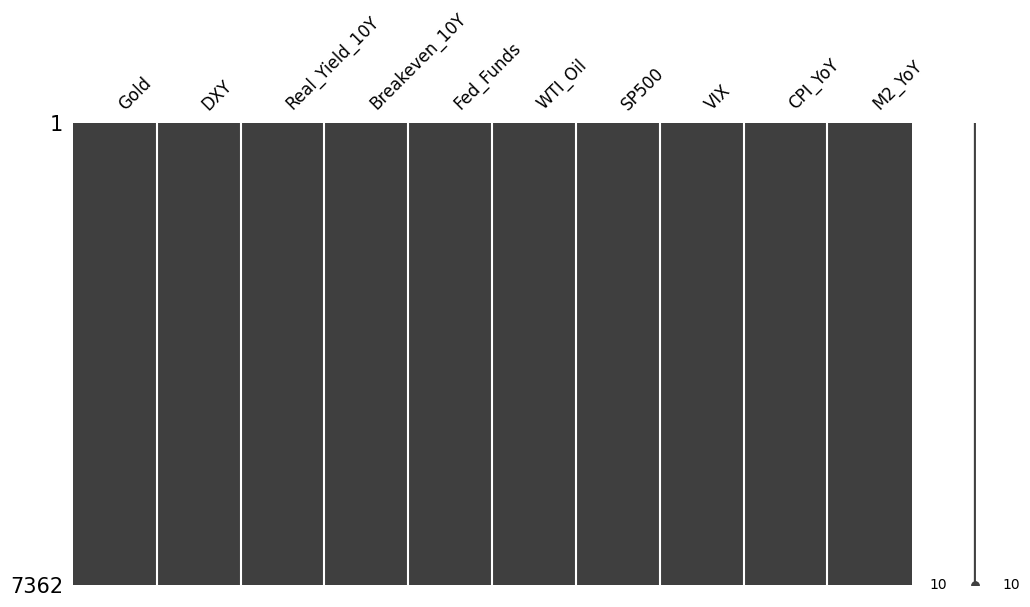

In [5]:
msno.matrix(final_data, figsize=(12, 6), fontsize=12)

# Optional: show plot
plt.show()

In [6]:
final_data.isna().sum()

Gold              0
DXY               0
Real_Yield_10Y    0
Breakeven_10Y     0
Fed_Funds         0
WTI_Oil           0
SP500             0
VIX               0
CPI_YoY           0
M2_YoY            0
dtype: int64

## Plotting raw data

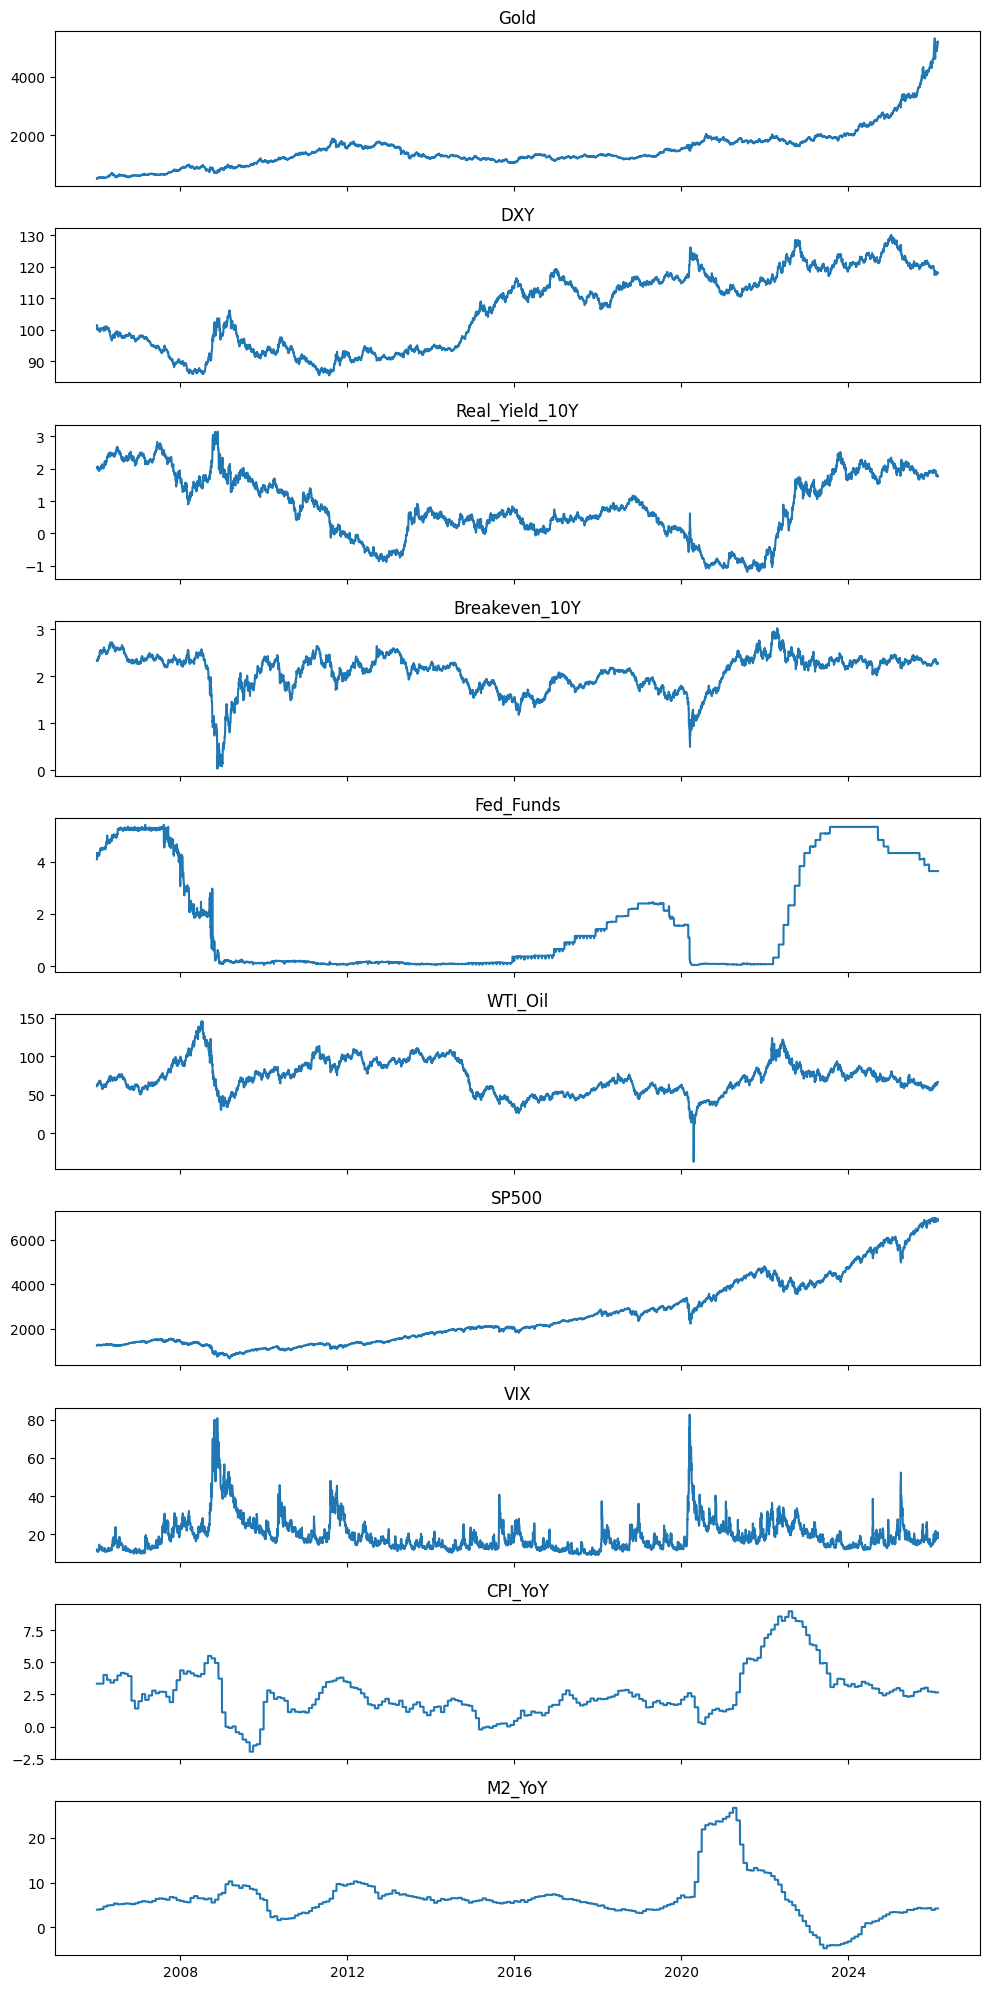

In [7]:
fig, axes = plt.subplots(10, 1, figsize=(10, 20), sharex=True)

for i, col in enumerate(final_data.columns):
    axes[i].plot(final_data.index, final_data[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Denoising data

In [8]:
import numpy as np
import pandas as pd

df = final_data.copy()

# Compute log return of gold (target)
df['gold_return'] = np.log(df['Gold']).diff()

# Smooth macro variables (causal)
macro_cols = [col for col in df.columns if col not in ['Gold','gold_return']]
df_macro_smooth = df[macro_cols].ewm(span=14, adjust=False).mean()

# Create lagged gold features
df_lags = df[['Gold']].copy()
df_lags['gold_lag1'] = df_lags['Gold'].shift(1)
df_lags['gold_lag2'] = df_lags['Gold'].shift(2)
df_lags = df_lags[['gold_lag1','gold_lag2']]  # only keep lagged features

# Combine features
X = pd.concat([df_macro_smooth, df_lags], axis=1)

# Target = next-day gold return
y = df['gold_return'].shift(-1)

# Drop rows with NA (from diff and shift)
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=['gold_return'])
y = data['gold_return']

## Plotting denoised exogenous data

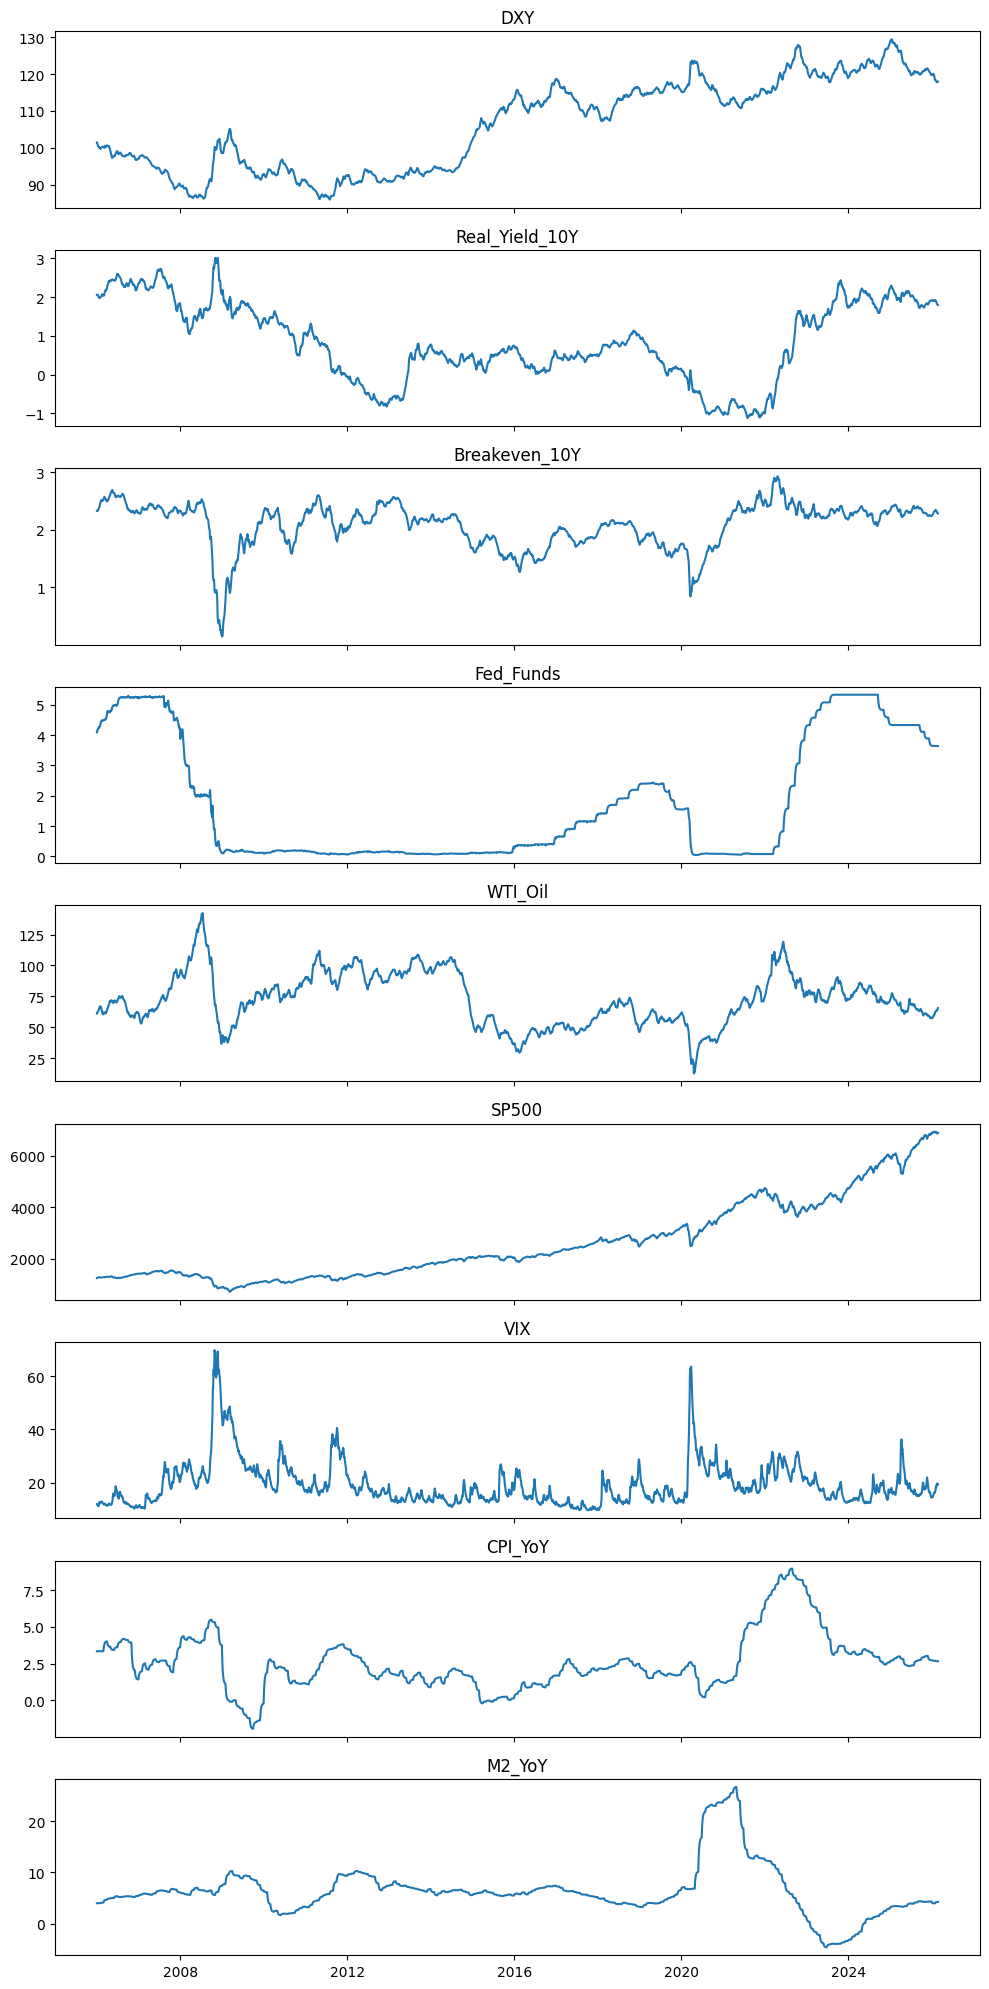

In [9]:
fig, axes = plt.subplots(9, 1, figsize=(10, 20), sharex=True)

for i, col in enumerate(df_macro_smooth.columns):
    axes[i].plot(df_macro_smooth.index, df_macro_smooth[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Plotting noise from the raw exogenous data

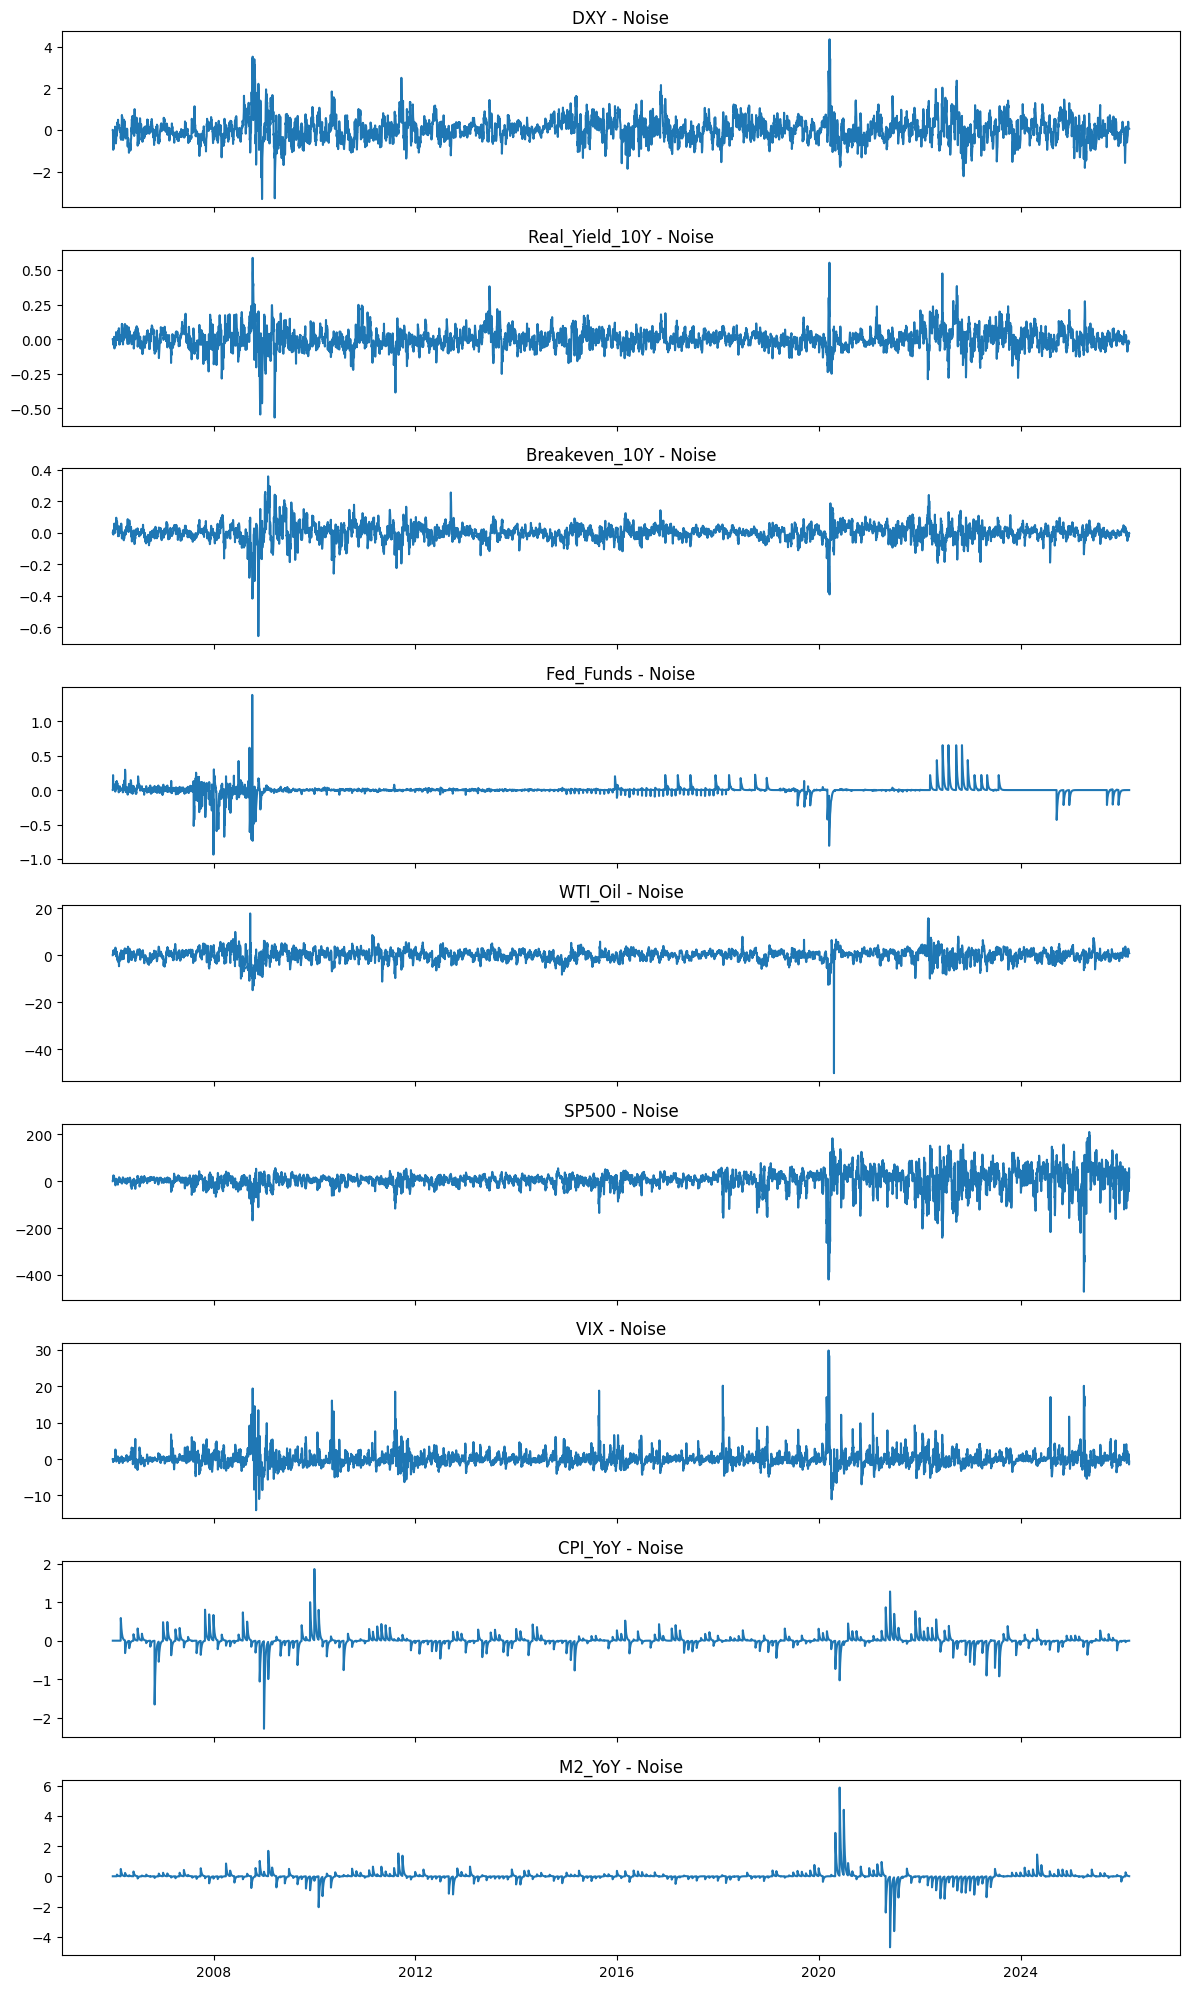

In [10]:
df_noise = df[macro_cols] - df_macro_smooth

fig, axes = plt.subplots(9, 1, figsize=(12, 20), sharex=True)

for i, col in enumerate(df_noise.columns):
    axes[i].plot(df_noise.index, df_noise[col])
    axes[i].set_title(f"{col} - Noise")

plt.tight_layout()
plt.show()

## Correlation heatmap between all variables

In [11]:
corr_matrix = final_data.corr()

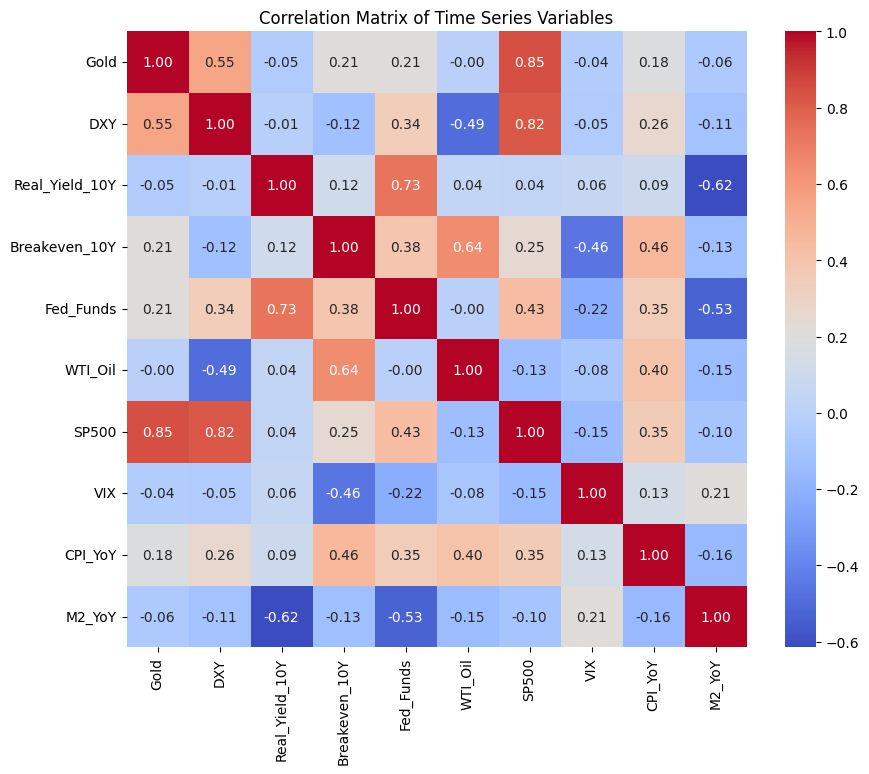

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 8))  # adjust size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Time Series Variables")
plt.show()